# Tutorial for `MDRefine` - 2

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

In [3]:
from MDRefine import load_data, minimizer, split_dataset, hyper_minimizer, MDRefinement, unwrap_dict

## 4. Ensemble + forward-model refinement

Simultaneous refinement of structural ensembles and forward models (Karplus equations) for RNA oligomers.

In this section, we are going to reproduce part of the results presented in *T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410.

In [1]:
%%bash

if [ ! -d "DATA" ]; then
    curl -O https://zenodo.org/records/14956459/files/DATA.zip

    unzip DATA.zip
    rm -r DATA.zip
fi

### a. Load data

In [4]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA'
infos['global']['system_names'] = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']  # , ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']  # , 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 10  # 00

In [5]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],#}
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

In [6]:
infos['global']['forward_model'] = forward_model_fun

In [7]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Define the regularization:

\begin{equation}
\begin{split}
R(A,B,C) & = \frac{1}{2\pi}\int_0^{2\pi} d\gamma\,(^3J(\gamma)-^3J_0(\gamma))^2 \\
& = \frac{1}{2\pi} \int_0^{2\pi} d\gamma \, [(A-A_0)\cos^2\gamma+(B-B_0)\cos\gamma+(C-C_0)]^2 \\
& = \frac{3}{8}(A-A_0)^2 + \frac{1}{2}(B-B_0)^2 + (C-C_0)^2 + (A-A_0)(C-C_0)
\end{split}
\end{equation}

which is 1/2 of the regularization proposed in *Simultaneous refinement of molecular dynamics ensembles
and forward models using experimental data* by Thorben Frohlking et al.

In [8]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [9]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

Let's use the `minimizer` function with the optimal hyperparameters $\alpha, \gamma$ determined in the above-mentioned paper, by Thorben Frohlking et al.

In [10]:
opt_alpha = 174.33288
opt_gamma = 3.43332*2

In [11]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, gamma=opt_gamma)

New evaluation:
loss:  276.74414988779466
gradient:  [ 0.32681744  0.59415378  1.22269368 -6.45176879 -6.94020089 -5.79031733
 15.54423237 -5.64225151 23.79733444] 

New evaluation:
loss:  271.5109681408496
gradient:  [-2.97935267e-01 -2.13989670e-03 -3.73841569e-01 -1.14275609e-01
  2.01997132e-01  7.42182106e+00 -8.53768861e+00  6.50189631e-01
 -1.94526846e+01] 

New evaluation:
loss:  270.26214894157545
gradient:  [-1.43888472 -1.48670177 -3.52214057  2.77806996  9.18139392  9.10888569
 -3.80097204 10.99291238 -8.23629917] 

New evaluation:
loss:  268.581238295214
gradient:  [-0.58415958 -0.85529777 -1.46195395  0.28141921  7.21400951  2.2748101
 -4.49780609  9.78837039 -8.58196138] 

New evaluation:
loss:  266.49408855090047
gradient:  [-0.37817227 -0.69144148 -1.01805439  2.70176896  8.38021718  5.38929578
 -3.21404643  4.17169688 -4.89898646] 

New evaluation:
loss:  265.80514401209007
gradient:  [-3.62260576 -3.06763381 -9.08383353  1.93214253  0.66956214  1.17064955
 -2.0718961

You may save the results in a folder `folder_name` with `save_txt` function of `MDRefine` package.

In [12]:
from MDRefine import save_txt

In [13]:
input_values = {'stride': stride, 'alpha': opt_alpha, 'beta': np.inf, 'gamma': opt_gamma}

coeff_names = data.properties.forward_coeffs_0.index

# input parameters: `input_values` dictionary, `Result` class instance, `coeff_names`, `folder_name`
save_txt(input_values, Result, coeff_names, folder_name='my_result_Karplus')

Let's analyse the results of `minimizer`

In [14]:
print(vars(Result).keys())

print('loss: ', Result.loss)
print('forward-model coefficients: ', Result.pars)
print('KL divergence: ', Result.D_KL_alpha)

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])
loss:  263.2999358620523
forward-model coefficients:  [ 9.76315833 -1.82439626 -0.05544103 16.80182399 -5.64933471  0.94026419
  8.65777611 -1.80901063 -0.0357319 ]
KL divergence:  {'AAAA': DeviceArray(0.03837672, dtype=float64), 'CAAU': DeviceArray(0.03221742, dtype=float64), 'CCCC': DeviceArray(0.00936817, dtype=float64), 'GACC': DeviceArray(0.0035901, dtype=float64), 'UUUU': DeviceArray(0.01323911, dtype=float64), 'UCAAUC': DeviceArray(0.04206142, dtype=float64)}


In [15]:
tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print('1/2 chi^2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*Result.reg_fm)
print('alpha*D_{KL, tot}: ', opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]))

print('loss: ', opt_gamma*Result.reg_fm + opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]) + 1/2*tot_chi2)


1/2 chi^2:  233.33047935280018
gamma*R:  5.762829438251873
alpha*D_{KL, tot}:  24.20663216795417
loss:  263.2999409590062


You can also look at `intermediates` attribute, namely, the intermediate steps of the minimization (function evaluation)

dict_keys(['loss', 'pars', 'lambdas', 'minis'])


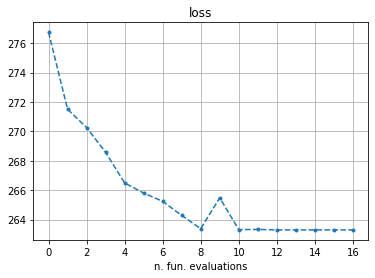

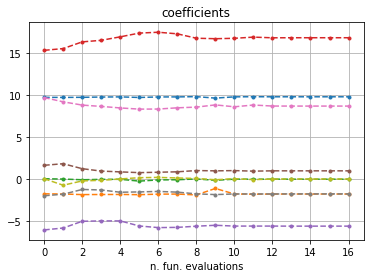

In [16]:
print(vars(Result.intermediates).keys())

plt.plot(Result.intermediates.loss, '.--')
plt.title('loss')
plt.xlabel('n. fun. evaluations')
plt.grid()

plt.figure()

inter_pars = Result.intermediates.pars

for i in range(inter_pars.shape[1]):
    plt.plot(Result.intermediates.pars[:,i], '.--')

plt.title('coefficients')
plt.xlabel('n. fun. evaluations')
plt.grid()

### c. Search for optimal hyperparameters

Let's use `hyper_minimizer` to search for the optimal hyperparameters $\alpha, \gamma$ in cross validation

In [17]:
hyper_search = hyper_minimizer(data, regularization=regularization, starting_alpha=100, starting_gamma=100, random_states=[0])


Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('alpha', 2.0), ('gamma', 2.0)]
New evaluation:
loss:  224.81689926180627
gradient:  [ 0.28398335  0.50907959  1.07402516 -5.15359849 -5.43567538 -4.29403356
 12.73622264 -5.51081765 20.31082057] 

New evaluation:
loss:  333.82190601212983
gradient:  [  -4.95615573   -1.87327388   -9.19276765   29.21371853   19.47363396
   55.14416199 -115.21541827   19.42955437 -208.53018355] 

New evaluation:
loss:  223.53345958968808
gradient:  [-0.22593089  0.27764569  0.07547857 -1.80559529 -3.00840363  1.49614059
  0.28434389 -3.08831071 -1.96815144] 

New evaluation:
loss:  231.75947024202804
gradient:  [ 0.06329442 -2.60877183 -0.44396253  1.15733384 28.25141637 -2.02251541
  5.57387884 30.30813315 12.23898724] 

New evaluation:
loss:  223.378162462609
gradient:  [-0.19214895 -0.06958444  0.01040634 -1.45032147  0.7374414   1.0751029
  0.91831393  0.91283867 -0.26475612] 

New evaluation:
loss:  223.332384304823

## 5. Fully combined refinement

Now, let's include the fitting of a force-field correction term to the previous refinement.

In this way, we are able to combine all the three different refinements (structural ensembles, force-field corrections and forward models) in a single framework. The results so obtained will be compared to those presented in the two papers 

*T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410

*I. Gilardoni et al., "Boosting ensemble refinement with transferable force-field corrections: synergistic optimization for molecular simulations", J. Phys. Chem. Letters 15.5 (2024)* https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423,

where ensemble refinement combined with the correction either of the force-field or the forward model is performed.

### a. Load data

take just two molecular systems and exclude the unobserved NOEs to run the script faster

In [18]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA'
infos['global']['system_names'] = ['AAAA','CAAU']  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']  # , ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']  # , 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 10

In [19]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [20]:
infos['global']['forward_model'] = forward_model_fun

In [21]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [22]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [23]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


Define the regularizations for the forward-model and the force-field corrections.

In [24]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2 + 1/2*(coeffs[1]-coeffs_0['B_gamma'])**2 + (coeffs[2]-coeffs_0['C_gamma'])**2 + (coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2 + 1/2*(coeffs[4]-coeffs_0['B_beta'])**2 + (coeffs[5]-coeffs_0['C_beta'])**2 + (coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2 + 1/2*(coeffs[7]-coeffs_0['B_sugar'])**2 + (coeffs[8]-coeffs_0['C_sugar'])**2 + (coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [25]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

Let's minimize the loss function with `minimizer` and optimal hyperparameters determined by calculations performed on the cluster and reported in our final paper https://arxiv.org/pdf/2411.07798.

In [26]:
alpha = 959.86
beta = 167.94
gamma = 0.42

In [27]:
Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

New evaluation:
loss:  124.27444906120486
gradient:  [-37.27142379   0.19500544   0.22764324   0.06155065   0.34493679
  -2.2911958   -2.6207376   -2.65506399   7.38442593  -5.25881161
  11.55335651] 

New evaluation:
loss:  303.70106012264
gradient:  [144.02892006 -21.42960716  -0.19076239  -0.59387234  -1.29009401
  -1.93463165  -2.19711042  -2.09054257   5.82981237  -4.7559485
   6.61525451] 

New evaluation:
loss:  123.7630177268237
gradient:  [23.58667222 -1.65073763  0.18575341  0.02373424  0.2257572  -2.3037095
 -2.63049383 -2.65404914  7.34571568 -5.26052297 11.3215456 ] 

New evaluation:
loss:  122.7613357995439
gradient:  [ 2.31432544e+01 -1.32389480e+00  1.82946692e-01  1.85568125e-02
  2.15157366e-01 -2.22630762e+00 -2.52566386e+00 -2.47265694e+00
  6.91508489e+00 -5.04864696e+00  1.05707817e+01] 

New evaluation:
loss:  119.38300526016565
gradient:  [ 2.13881918e+01 -6.55163672e-03  1.74062391e-01  7.64839296e-04
  1.79774319e-01 -1.91606652e+00 -2.10498852e+00 -1.74359556

In [28]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [29]:
Result.pars

array([ 0.02803469,  0.02289812,  8.93990372, -1.78364698,  0.19955274,
       18.23894024, -5.18600179,  0.28082936,  8.18253371, -1.2864042 ,
       -0.20278584])

In [30]:
Result.mini

      fun: 112.27487937242095
 hess_inv: array([[ 6.74946690e-04,  4.15890079e-04, -8.37881732e-04,
        -2.44750631e-04,  4.91529526e-04,  1.77113934e-03,
         9.44598210e-05, -6.15697594e-04, -2.50446808e-03,
         3.50870633e-05,  1.83664983e-03],
       [ 4.15890079e-04,  1.29120632e-02, -1.51708668e-02,
        -2.22101834e-04,  3.72523374e-03,  1.85707108e-02,
         3.32800006e-03, -9.40253314e-03, -1.98494147e-02,
        -3.97772851e-03,  1.94887746e-02],
       [-8.37881732e-04, -1.51708668e-02,  5.76336922e+00,
         8.77029979e-01, -2.22549143e+00,  5.21643911e-01,
         2.05298701e-02, -2.36642751e-01, -1.15410409e+00,
        -1.63919032e-01,  1.16975796e+00],
       [-2.44750631e-04, -2.22101834e-04,  8.77029979e-01,
         1.07160084e+00, -7.09961504e-01,  1.80813696e-01,
         4.17518810e-02, -1.00478476e-01, -4.03495136e-01,
        -5.20871187e-02,  3.81791477e-01],
       [ 4.91529526e-04,  3.72523374e-03, -2.22549143e+00,
        -7.09961504e

In [31]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

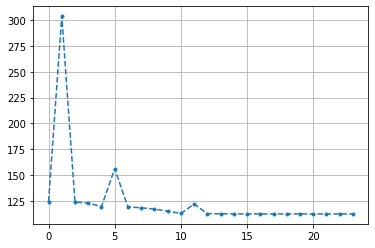

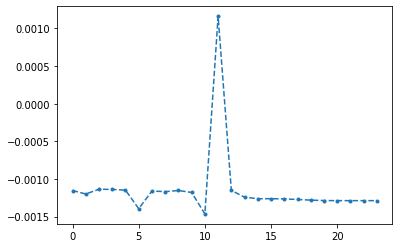

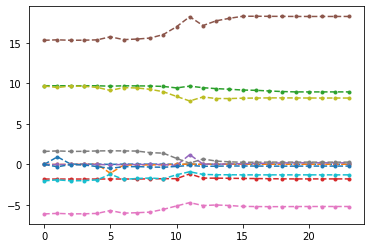

In [32]:
inter_loss = Result.intermediates.loss
plt.plot(inter_loss, '.--')
plt.grid()

plt.figure()

inter_lambdas = np.array(Result.intermediates.lambdas)
plt.plot(inter_lambdas[:,0], '.--')

plt.figure()
plt.plot(Result.intermediates.pars, '.--')
plt.show()

### c. Determine optimal hyper-parameters through cross validation

Scan over the hyperparameters: now we are in a 3-dimensional space, so the calculations are cumbersome.

Let's split the data set into training and validation set just once (with `split_dataset`) and then minimize the loss function with `minimizer` with several values of the hyperparameters (scan in logarithmic scale).

In [33]:
data_train, data_valid, valid_obs, valid_frames = split_dataset(data, random_state=1)

Input random_state employed both for valid_obs and valid_frames


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


In [34]:
delta = 2.0

log10_alphas = np.arange(-2, 2 + delta, delta)
log10_betas = np.array([-2.0, 0.0, 2.0])
log10_gammas = log10_alphas

Results = {}

for log10_alpha in log10_alphas:
    Results[log10_alpha] = {}

    for log10_beta in log10_betas:
        Results[log10_alpha][log10_beta] = {}
    
        for log10_gamma in log10_gammas:
            print(log10_alpha, log10_beta, log10_gamma)
    
            Results[log10_alpha][log10_beta][log10_gamma] = minimizer(data_train, regularization=regularization, alpha=10**log10_alpha, beta=10**log10_beta, gamma=10**log10_gamma, data_valid=data_valid)

            clear_output()

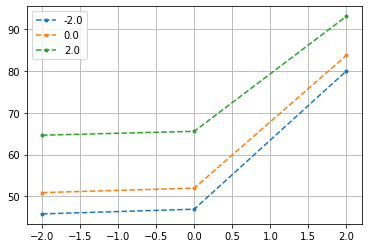

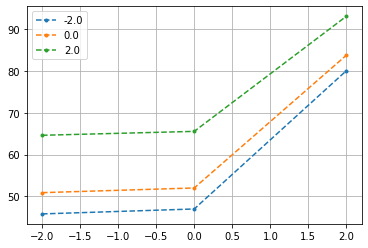

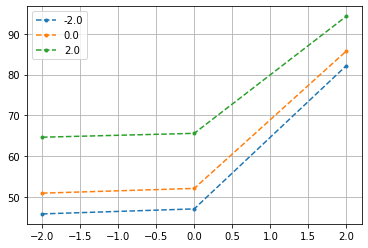

In [35]:
for log10_beta in log10_betas:

    plt.figure()

    for log10_gamma in log10_gammas:
        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        plt.plot(log10_alphas, loss, '.--', label=log10_gamma)

    plt.legend()
    plt.grid()

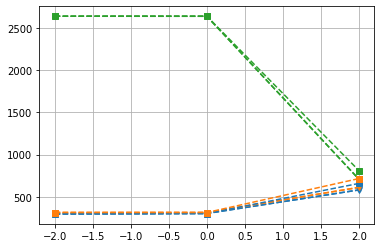

In [36]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray','tab:olive','tab:cyan']
markers = ['.','v','s','*','D','o','^','<','>','p','P','+','X','d']

for i,log10_beta in enumerate(log10_betas):

    # plt.figure()

    for j,log10_gamma in enumerate(log10_gammas):
        chi2 = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2)) for log10_alpha in log10_alphas])
        chi2_valid = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_valid)) for log10_alpha in log10_alphas])
        chi2_new_obs = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_new_obs)) for log10_alpha in log10_alphas])

        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        
        # plt.plot(log10_alphas, loss, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2, markers[i] + '--', color = colors[j], label = log10_gamma)
        plt.plot(log10_alphas, chi2_valid, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2_new_obs, markers[i] + '--', color = colors[j], label = log10_gamma)

    # plt.legend()
    plt.grid()

### d. automatic optimization of hyper parameters

In [37]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=1, starting_beta=1, starting_gamma=1, random_states=2, which_set='validation')


Input random_state employed both for valid_obs and valid_frames
Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('alpha', 0.0), ('beta', 0.0), ('gamma', 0.0)]


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


av. chi2:  355.2551544734829
av. gradient:  [0.32495284 0.03615603 5.39401288]

log10 hyperpars:  [('alpha', -0.060132877654345454), ('beta', -0.006690713447741501), ('gamma', -0.9981679574994219)]
av. chi2:  355.6231717013116
av. gradient:  [ 1.49374331 -0.04239025  0.04531706]

log10 hyperpars:  [('alpha', -0.017438385806558546), ('beta', -0.0019402903531993924), ('gamma', -0.2894662391291961)]
av. chi2:  354.6748397965819
av. gradient:  [ 0.67919794  0.02893792 -0.62172831]


In [38]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2)


Input random_state employed both for valid_obs and valid_frames
Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('alpha', 1.2999999999999998), ('beta', -2.1999999999999997), ('gamma', -3.5)]
av. chi2:  339.3052617610266
av. gradient:  [ 1.05489550e+02 -2.55043089e-02 -5.16593998e+00]

log10 hyperpars:  [('alpha', 0.3011969613512695), ('beta', -2.1997585184385033), ('gamma', -3.451087510053992)]
av. chi2:  332.01776184972306
av. gradient:  [-23.40388942  -0.06971844   4.92051829]


In [39]:
alpha, beta, gamma = 10**hyper_out.x

Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

New evaluation:
loss:  74.60169401711153
gradient:  [-1.23665673e+00 -8.95523229e-03  1.86210038e-01 -2.21702470e-01
  1.28811717e-01 -2.51397907e+00 -2.96983369e+00 -3.41976521e+00
  8.76977035e+00 -7.16028867e+00  1.21932647e+01] 

New evaluation:
loss:  63.02825679599095
gradient:  [-0.40166436 -0.02973492  0.18626947 -0.240011    0.11843903 -1.48970019
 -1.46586277 -0.90584576  3.0689604  -3.92971306  2.28712254] 

New evaluation:
loss:  73.57110792441883
gradient:  [ 5.94085581e-01  3.38382901e-03  5.67490517e-02 -3.66029774e-01
 -2.96710012e-01  1.85336194e+00  3.30577166e+00  6.63736163e+00
  3.11232893e+00  9.38797383e+00  5.30536185e+00] 

New evaluation:
loss:  60.705219086470414
gradient:  [-0.07606714 -0.01515457  0.14314747 -0.28260672 -0.01671581 -0.48493809
 -0.03883366  1.34480765  3.19695355 -0.04924009  3.21606418] 

New evaluation:
loss:  60.79207571877388
gradient:  [-0.77176669  0.04835152  0.2813104  -0.1394721   0.33251245 -2.71712311
 -3.51511425 -4.87157321 -0.

In [40]:
out = MDRefinement(infos, regularization=regularization, stride=stride, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2, results_folder_name='../../my_results')

loading data from directory...
loading  AAAA
loading  CAAU
done

search for optimal hyperparameters ...
Input random_state employed both for valid_obs and valid_frames
Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('alpha', 1.2999999999999998), ('beta', -2.1999999999999997), ('gamma', -3.5)]


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


av. chi2:  339.3052617610266
av. gradient:  [ 1.05489550e+02 -2.55043089e-02 -5.16593998e+00]

log10 hyperpars:  [('alpha', 0.3011969613512695), ('beta', -2.1997585184385033), ('gamma', -3.451087510053992)]
av. chi2:  332.01776184972306
av. gradient:  [-23.40388942  -0.06971844   4.92051829]

optimal hyperparameters: alpha: 2.0007690532280065 beta: 0.006313082744108295 gamma: 0.000353926018036803

refinement with optimal hyperparameters...
New evaluation:
loss:  74.60169401711153
gradient:  [-1.23665673e+00 -8.95523229e-03  1.86210038e-01 -2.21702470e-01
  1.28811717e-01 -2.51397907e+00 -2.96983369e+00 -3.41976521e+00
  8.76977035e+00 -7.16028867e+00  1.21932647e+01] 

New evaluation:
loss:  63.02825679599095
gradient:  [-0.40166436 -0.02973492  0.18626947 -0.240011    0.11843903 -1.48970019
 -1.46586277 -0.90584576  3.0689604  -3.92971306  2.28712254] 

New evaluation:
loss:  73.57110792441883
gradient:  [ 5.94085581e-01  3.38382901e-03  5.67490517e-02 -3.66029774e-01
 -2.96710012e-01

In [41]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([339.30526176, 332.01776185], dtype=float64),
 'av_gradient': DeviceArray([[ 1.05489550e+02, -2.55043089e-02, -5.16593998e+00],
              [-2.34038894e+01, -6.97184389e-02,  4.92051829e+00]],            dtype=float64),
 'log10_hyperpars': DeviceArray([[ 1.3       , -2.2       , -3.5       ],
              [ 0.30119696, -2.19975852, -3.45108751]], dtype=float64)}

if you do not specify some hyper parameters, as for example $\gamma$, you are fixing it to $+\infty$ (no refinement in that "direction")

In [42]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=0.1, starting_beta=10, random_states=2, gtol=0.1)


Input random_state employed both for valid_obs and valid_frames
Input random_state employed both for valid_obs and valid_frames

log10 hyperpars:  [('alpha', -0.9999999999999998), ('beta', 1.0)]


../MDRefine/loss_and_minimizer.py:1144: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w = data_mol.weights[valid_frames_mol]


av. chi2:  1527.9573632504485
av. gradient:  [ 3.30974499e-17 -3.31988429e-17]


In [43]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([1527.95736325], dtype=float64),
 'av_gradient': DeviceArray([[ 3.30974499e-17, -3.31988429e-17]], dtype=float64),
 'log10_hyperpars': DeviceArray([[-1.,  1.]], dtype=float64)}